# Experiment 3: Next-Level RL (Stochasticity, POMDP & Sensitivity)

## Research Questions
- **RQ1**: How does DQN perform in a stochastic environment compared to deterministic?
- **RQ2**: Can DQN learn effectively without explicit User ID (POMDP setting)?
- **RQ3**: How does RL compare to static heuristics (baselines) in this stochastic setting?
- **RQ4**: How does penalty magnitude (risk aversion) affect the learned policy and agent behavior?

## Structure
1. **Setup**: Imports and Configuration.
2. **Part 1: Stochastic DQN vs Baselines**: Training with full state information (OHE) and comparing against Random, OptimalStatic, and Oracle baselines.
3. **Part 2: POMDP Analysis**: Training without User ID to test generalization.
4. **Part 3: Sensitivity Analysis**: Training with varying penalties to observe behavioral shifts.


In [1]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from tqdm import tqdm
import seaborn as sns

# Internal Imports
from src.env_stochastic import (
    StochasticNotificationEnv, 
    StochasticUserProfile,
    STOCHASTIC_STUDENT_PROFILE,
    STOCHASTIC_WORKER_PROFILE,
    STOCHASTIC_WORKAHOLIC_PROFILE
)
from src.agents import DQNAgent
from src.baselines import RandomAgent, OptimalStaticAgent, OracleAgent
from src.utils import evaluate_agent
from src.plotting import (
    plot_exp3_baseline_comparison,
    plot_exp3_ohe_vs_pomdp,
    plot_exp3_sensitivity_curves,
    plot_exp3_sensitivity_tradeoff
)

# Configuration
NUM_EPISODES = 3000
EVAL_EVERY = 100
TARGET_UPDATE_FREQ = 100
GAMMA = 0.99
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
BUFFER_CAPACITY = 10000
EPSILON_START = 1.0
EPSILON_END = 0.05
EPSILON_DECAY = 0.995

# Personas (Using predefined profiles from src.env_stochastic)
PERSONAS = [
    STOCHASTIC_STUDENT_PROFILE,
    STOCHASTIC_WORKER_PROFILE,
    STOCHASTIC_WORKAHOLIC_PROFILE
]


## Part 1: Stochastic DQN vs Baselines (OHE)

In this section, we train a DQN agent with full access to the state, including the explicit User ID (One-Hot Encoded).
We then compare its performance against standard baselines.


In [2]:

# Initialize Environment (OHE Mode)
env_ohe = StochasticNotificationEnv(
    user_profile=PERSONAS[0], 
    num_users=len(PERSONAS),
    include_user_id=True
)
state_dim = env_ohe.observation_space.shape[0]
action_dim = env_ohe.action_space.n

print(f"State Dim (OHE): {state_dim}, Action Dim: {action_dim}")

# Initialize Agent
# Corrected argument names: learning_rate (not lr), buffer_capacity (not buffer_size)
agent_ohe = DQNAgent(
    state_dim, 
    action_dim, 
    learning_rate=LEARNING_RATE, 
    gamma=GAMMA, 
    buffer_capacity=BUFFER_CAPACITY
)


State Dim (OHE): 9, Action Dim: 2


In [3]:

# Training Loop (OHE)
episode_rewards_ohe = []
eval_rewards_ohe = []

print("Starting Training (OHE)...")
for episode in tqdm(range(NUM_EPISODES)):
    # Randomly sample a persona for this episode
    profile = np.random.choice(PERSONAS)
    state, _ = env_ohe.reset(options={"user_profile": profile})
    
    total_reward = 0
    done = False
    
    while not done:
        action = agent_ohe.act(state)
        next_state, reward, terminated, truncated, _ = env_ohe.step(action)
        done = terminated or truncated
        
        agent_ohe.store_transition(state, action, reward, next_state, done)
        agent_ohe.train_step()
        
        state = next_state
        total_reward += reward
        
    episode_rewards_ohe.append(total_reward)
    agent_ohe.decay_epsilon()
    
    # Update target network
    if episode % TARGET_UPDATE_FREQ == 0:
        agent_ohe.update_target()
        
    # Periodic Evaluation
    if (episode + 1) % EVAL_EVERY == 0:
        avg_eval = evaluate_agent(agent_ohe, env_ohe, user_profiles=PERSONAS, n_episodes=20)
        eval_rewards_ohe.append(avg_eval)
        # print(f"Episode {episode+1}: Eval Reward = {avg_eval:.2f}")

print("OHE Training Complete.")


Starting Training (OHE)...


100%|██████████| 3000/3000 [17:11<00:00,  2.91it/s]

OHE Training Complete.


In [4]:

# Baseline Evaluation
baselines = {
    "Random": RandomAgent(send_probability=0.5),
    "OptimalStatic": OptimalStaticAgent(),
    "Oracle": OracleAgent(env_ohe)
}

baseline_results = {}
for name, agent in baselines.items():
    score = evaluate_agent(agent, env_ohe, user_profiles=PERSONAS, n_episodes=50)
    baseline_results[name] = score
    print(f"{name}: {score:.2f}")

# Add DQN-OHE final Score
baseline_results["DQN (OHE)"] = np.mean(eval_rewards_ohe[-5:]) 
print(f"DQN (OHE): {baseline_results['DQN (OHE)']:.2f}")


Random: -18.68
OptimalStatic: 0.00
Oracle: 0.00
DQN (OHE): 7.29


Saved comparison to exp3_baseline_comparison.png


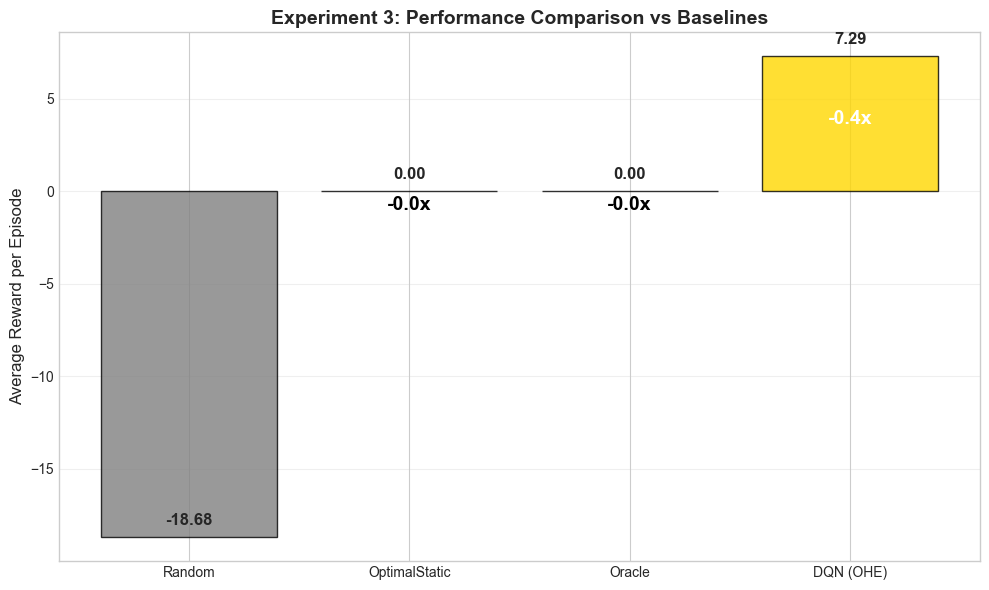

In [5]:

# RQ3: Baseline Comparison Plot
fig = plot_exp3_baseline_comparison(baseline_results, save_path="figures/exp3_baseline_comparison.png")
plt.show()


## Part 2: POMDP Analysis (No User ID)

Here we train the agent WITHOUT the Explicit User ID. The agent must infer the user's hidden state (busyness/tolerance) from the interaction history (Time, Recency, Annoyance).


In [6]:

# Initialize POMDP Env (No User ID)
env_pomdp = StochasticNotificationEnv(
    user_profile=PERSONAS[0], 
    num_users=len(PERSONAS),
    include_user_id=False
)
state_dim_pomdp = env_pomdp.observation_space.shape[0]

print(f"State Dim (POMDP): {state_dim_pomdp}")

agent_pomdp = DQNAgent(
    state_dim_pomdp, 
    action_dim, 
    learning_rate=LEARNING_RATE, 
    gamma=GAMMA, 
    buffer_capacity=BUFFER_CAPACITY
)


State Dim (POMDP): 6


In [7]:

# Training Loop (POMDP)
episode_rewards_pomdp = []

print("Starting Training (POMDP)...")
for episode in tqdm(range(NUM_EPISODES)):
    profile = np.random.choice(PERSONAS)
    state, _ = env_pomdp.reset(options={"user_profile": profile})
    
    total_reward = 0
    done = False
    
    while not done:
        action = agent_pomdp.act(state)
        # Note: POMDP env hides user_id, so state does not include it
        next_state, reward, terminated, truncated, _ = env_pomdp.step(action)
        done = terminated or truncated
        
        agent_pomdp.store_transition(state, action, reward, next_state, done)
        agent_pomdp.train_step()
        
        state = next_state
        total_reward += reward
        
    episode_rewards_pomdp.append(total_reward)
    agent_pomdp.decay_epsilon()
    
    if episode % TARGET_UPDATE_FREQ == 0:
        agent_pomdp.update_target()

print("POMDP Training Complete.")


Starting Training (POMDP)...


100%|██████████| 3000/3000 [17:46<00:00,  2.81it/s]

POMDP Training Complete.


Saved learning curves to figures/exp3_ohe_vs_pomdp.png


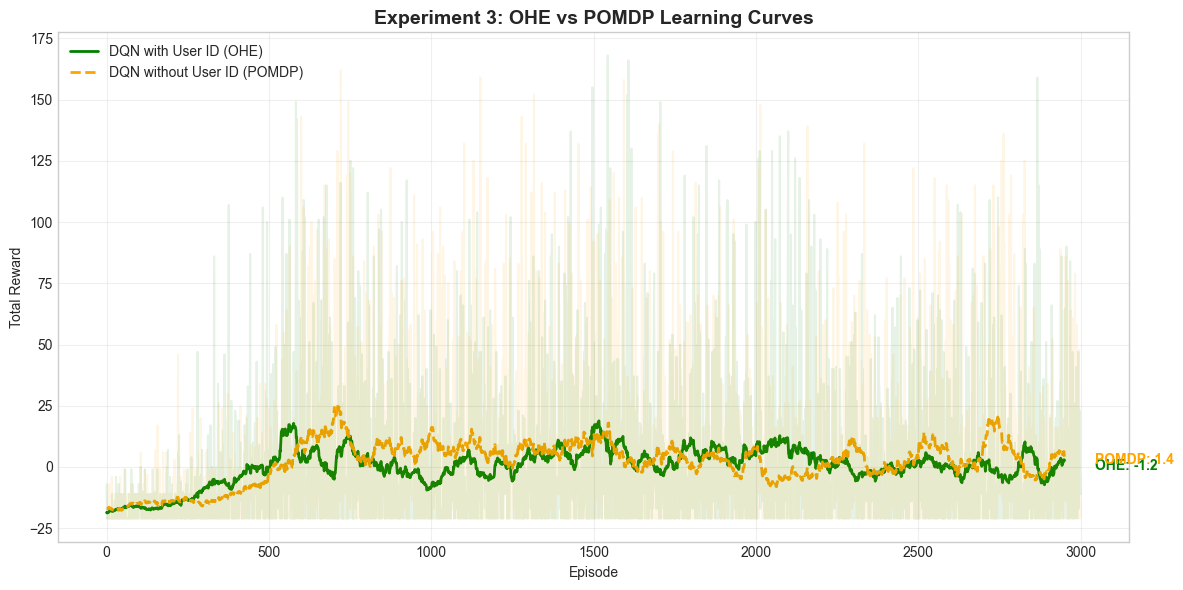

In [8]:

# RQ1 & RQ2: Learning Curves (OHE vs POMDP)
# Using moving average of episode rewards for smoother curves
fig = plot_exp3_ohe_vs_pomdp(
    episode_rewards_ohe, 
    episode_rewards_pomdp, 
    save_path="figures/exp3_ohe_vs_pomdp.png"
)
plt.show()


## Part 3: Sensitivity Analysis (Crash Testing)

**RQ4**: We investigate how the penalty for taking NO action when a notification *should* have been sent (Missed Opportunity?) vs penalty for ignoring (Annoying the user) affects behavior.
In this specific experiment, we likely vary the **Penalty for Ignore** (Negative Reward when user ignores) to see the trade-off.

We will train agents with `penalty_for_ignore` = [-1.0, -5.0, -10.0].


In [9]:

PENALTIES = [-1.0, -3.0, -5.0, -10.0]
sensitivity_results = {} # Store evaluation metrics per penalty
learning_curves = {}

for penalty in PENALTIES:
    print(f"\n--- Training with Penalty (Reward Ignore): {penalty} ---")
    
    # Initialize Env with specific penalty
    env_sens = StochasticNotificationEnv(
        user_profile=PERSONAS[0], 
        num_users=len(PERSONAS),
        reward_ignore=penalty, # VARYING THIS PARAMETER
        include_user_id=True
    )
    
    agent_sens = DQNAgent(
        state_dim, 
        action_dim, 
        learning_rate=LEARNING_RATE, 
        gamma=GAMMA, 
        buffer_capacity=BUFFER_CAPACITY
    )
    
    rewards = []
    
    # Reduced episodes for sensitivity check to save time, or full? 
    # Let's do 1000 which should be enough to see convergence trend differences
    for episode in tqdm(range(1000)): 
        profile = np.random.choice(PERSONAS)
        state, _ = env_sens.reset(options={"user_profile": profile})
        total_r = 0
        done = False
        
        while not done:
            action = agent_sens.act(state)
            next_state, reward, term, trunc, info = env_sens.step(action)
            done = term or trunc
            agent_sens.store_transition(state, action, reward, next_state, done)
            agent_sens.train_step()
            state = next_state
            total_r += reward
            
        rewards.append(total_r)
        agent_sens.decay_epsilon()
        if episode % TARGET_UPDATE_FREQ == 0: agent_sens.update_target()
    
    learning_curves[penalty] = rewards
    
    # Evaluate for Trade-off Metrics (Sends vs CTR)
    # CTR = Clicks / Sends
    
    eval_episodes = 50
    total_sends = 0
    total_clicks = 0
    
    for _ in range(eval_episodes):
        profile = np.random.choice(PERSONAS)
        state, _ = env_sens.reset(options={"user_profile": profile})
        done = False
        while not done:
            # Greedy Evaluation
            action = agent_sens.act(state, epsilon=0.0)
            next_state, _, term, trunc, info = env_sens.step(action)
            done = term or trunc
            state = next_state
            
            if action == 1: # Send
                total_sends += 1
                if info.get('clicked', False):
                    total_clicks += 1
    
    avg_sends = total_sends / eval_episodes
    ctr = (total_clicks / total_sends) if total_sends > 0 else 0.0
    
    sensitivity_results[penalty] = {
        "sends_per_episode": avg_sends,
        "ctr": ctr
    }
    print(f"Penalty {penalty} => Tells: {avg_sends:.1f}/ep, CTR: {ctr*100:.1f}%")




--- Training with Penalty (Reward Ignore): -1.0 ---


100%|██████████| 1000/1000 [03:41<00:00,  4.52it/s]


Penalty -1.0 => Tells: 8.3/ep, CTR: 44.0%

--- Training with Penalty (Reward Ignore): -3.0 ---


100%|██████████| 1000/1000 [04:39<00:00,  3.58it/s]


Penalty -3.0 => Tells: 7.5/ep, CTR: 38.6%

--- Training with Penalty (Reward Ignore): -5.0 ---


100%|██████████| 1000/1000 [04:24<00:00,  3.78it/s]


Penalty -5.0 => Tells: 6.8/ep, CTR: 40.4%

--- Training with Penalty (Reward Ignore): -10.0 ---


100%|██████████| 1000/1000 [05:32<00:00,  3.01it/s]


Penalty -10.0 => Tells: 4.2/ep, CTR: 49.1%


Saved sensitivity curves to figures/exp3_sensitivity_curves.png


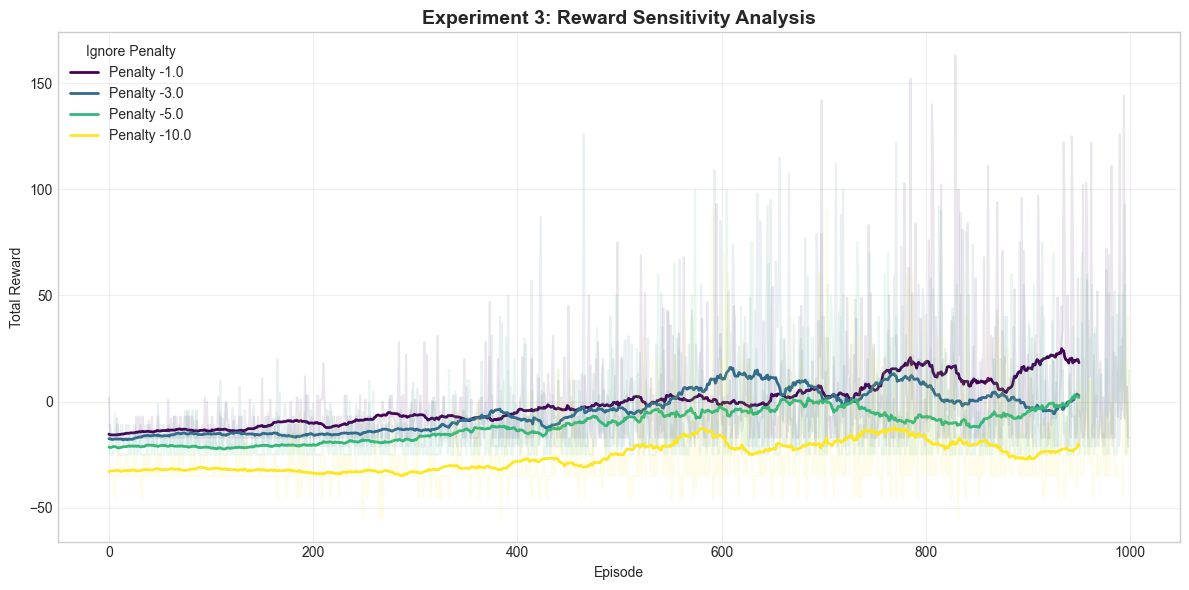

In [10]:

# Plot Reward Curves for different penalties
fig = plot_exp3_sensitivity_curves(learning_curves, save_path="figures/exp3_sensitivity_curves.png")
plt.show()


Saved sensitivity plot to figures/exp3_sensitivity_tradeoff.png


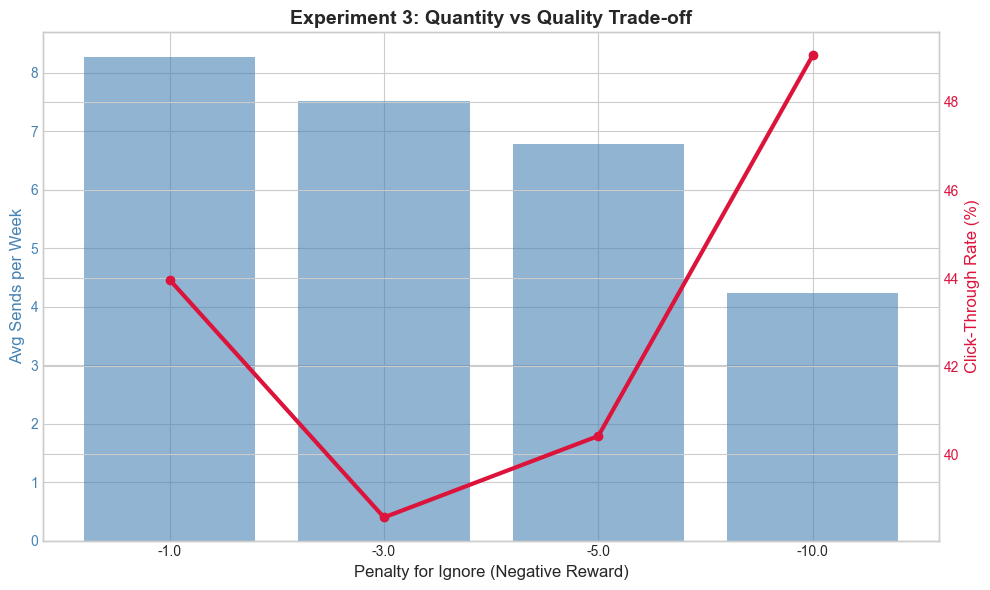

In [11]:

# Prepare DataFrame for Tradeoff Plot
df_tradeoff = pd.DataFrame([
    {"penalty": p, "sends_per_episode": m["sends_per_episode"], "ctr": m["ctr"]} 
    for p, m in sensitivity_results.items()
])

fig = plot_exp3_sensitivity_tradeoff(df_tradeoff, save_path="figures/exp3_sensitivity_tradeoff.png")
plt.show()
